## Set up environment

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

## Read into spark dataframe from csv in s3

In [4]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'bl2fh/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [6]:
df

DataFrame[customerID: string, gender: string, SeniorCitizen: bigint, Partner: string, Dependents: string, tenure: bigint, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: string, Churn: string]

## Write parquet to s3

In [7]:
parquetPath = '/home/ec2-user/SageMaker/bl2fh/bl2fh-pqt2'
df.write.parquet(parquetPath)
# need to delete the folder before re-run

In [8]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

In [9]:
s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"bl2fh-pqt/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "bl2fh-pqt"+f)

## Write to spark dataframe from parquet

In [10]:
df = sqlc.read.parquet(parquetPath)

In [11]:
df

DataFrame[customerID: string, gender: string, SeniorCitizen: bigint, Partner: string, Dependents: string, tenure: bigint, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: string, Churn: string]

## Analysis using MLlib

### Setup a sample dataframe

In [12]:
bucket='odl-spark19spds6003-001'
data_key = 'bl2fh/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)

In [13]:
pddf.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [14]:
pddf['tenure'] = pd.to_numeric(pddf['tenure']).astype(float)
pddf['SeniorCitizen'] = pd.to_numeric(pddf['SeniorCitizen']).astype(float)

In [15]:
pddf['TotalCharges'] = pd.to_numeric(pddf['TotalCharges'], errors='coerce')

In [16]:
pddf.dtypes

customerID           object
gender               object
SeniorCitizen       float64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [17]:
df = sqlc.createDataFrame(pddf) 

In [18]:
pddf = pddf.dropna() 

In [19]:
df = sqlc.createDataFrame(pddf)

### Explore the data

In [20]:
display(df)

DataFrame[customerID: string, gender: string, SeniorCitizen: double, Partner: string, Dependents: string, tenure: double, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string]

In [21]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [22]:
df.take(5)

[Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen=0.0, Partner='Yes', Dependents='No', tenure=1.0, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges=29.85, Churn='No'),
 Row(customerID='5575-GNVDE', gender='Male', SeniorCitizen=0.0, Partner='No', Dependents='No', tenure=34.0, PhoneService='Yes', MultipleLines='No', InternetService='DSL', OnlineSecurity='Yes', OnlineBackup='No', DeviceProtection='Yes', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='One year', PaperlessBilling='No', PaymentMethod='Mailed check', MonthlyCharges=56.95, TotalCharges=1889.5, Churn='No'),
 Row(customerID='3668-QPYBK', gender='Male', SeniorCitizen=0.0, Partner='No', Dependents='No', tenure=2.0, PhoneService='Yes', M

In [23]:
print("Pearson's r(tenure,TotalCharges) = {}".format(df.corr("tenure", "TotalCharges")))
print("Pearson's r(tenure,MonthlyCharges) = {}".format(df.corr("tenure", "MonthlyCharges")))
print("Pearson's r(MonthlyCharges,TotalCharges) = {}".format(df.corr("MonthlyCharges", "TotalCharges")))

Pearson's r(tenure,TotalCharges) = 0.8258804609332019
Pearson's r(tenure,MonthlyCharges) = 0.24686176664089363
Pearson's r(MonthlyCharges,TotalCharges) = 0.6510648032262017


### Select two numeric features for analysis
        MonthlyCharges = feature
        tenure = label

In [24]:
df = df.select("TotalCharges","tenure")

## Machine Learning

In [25]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 5619, test set N = 1413


### Vectorization

In [26]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [27]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("TotalCharges", "oneElementVec(tenure) as tenure")
testDF = testDF.selectExpr("TotalCharges", "oneElementVec(tenure) as tenure")

print(testDF.orderBy(testDF.TotalCharges.desc()).limit(5))

DataFrame[TotalCharges: double, tenure: vector]


In [28]:
# rename columns
trainingDF = trainingDF.withColumnRenamed("TotalCharges", "label").withColumnRenamed("tenure", "features")
testDF = testDF.withColumnRenamed("TotalCharges", "label").withColumnRenamed("tenure", "features")

### Train model using linear regression

In [29]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [30]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

### Append prediction column to testDF in the new dataframe predictionsAndLabelsDF

In [31]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=8349.45, features=DenseVector([72.0]), prediction=5292.659905915617), Row(label=8317.95, features=DenseVector([72.0]), prediction=5292.659905915617), Row(label=8250.0, features=DenseVector([70.0]), prediction=5140.332956007977), Row(label=8248.5, features=DenseVector([72.0]), prediction=5292.659905915617), Row(label=8182.85, features=DenseVector([69.0]), prediction=5064.169481054158)]


### Model evaluation

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [33]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [34]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

1234.18998789403

In [35]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.6964470467767812

## Visualization

In [47]:
df2 = predictionsAndLabelsDF.toPandas()

In [48]:
df2['Tenure'] = pddf['tenure']

In [51]:
df2 = df2.drop(columns = ['features'])

In [52]:
df2 = df2.rename(columns = {'label':'ActualTotalCharges'})
df2 = df2.rename(columns = {'prediction':'PredictedTotalCharges'})

In [54]:
df2.tail(10)

,ActualTotalCharges,PredictedTotalCharges,Tenure
1403,8061.50,5292.659906,8.0
1404,8075.35,5292.659906,35.0
1405,8100.25,5216.496431,1.0
1406,8109.80,5292.659906,66.0
1407,8129.30,5292.659906,8.0
1408,8182.85,5064.169481,71.0
1409,8248.50,5292.659906,43.0
1410,8250.00,5140.332956,2.0
1411,8317.95,5292.659906,29.0
1412,8349.45,5292.659906,15.0


In [59]:
import matplotlib.pyplot as plt

x = df2['Tenure']
y1 = df2['ActualTotalCharges']
y2 = df2['PredictedTotalCharges']

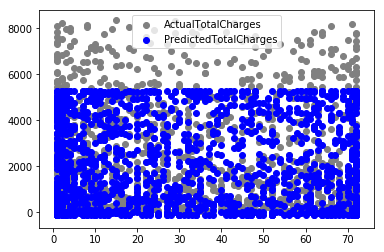

In [62]:
# Plot
fig, ax = plt.subplots()
ax.margins(0.05)

plt.scatter(x, y1, marker='o', color='gray');
plt.scatter(x, y2, marker='o', color='blue');

ax.legend()

plt.show()